### CIFAR-10 Object Classification Challenge - Kaggle
<!-- #### CNN Pytorch, CUDA GPU: Nvidia GTX 960 -->

#### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import cv2

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

#### Load the data

In [3]:
# path_train="./data/CIFAR-10/train"
# path_test="./data/CIFAR-10/test"

In [4]:
transform=transforms.Compose([
            transforms.ToTensor(),
                             ])

In [5]:
trainset=datasets.CIFAR10("./data/cifar/train",train=True, download=True, transform=transform)
testset=datasets.CIFAR10("./data/cifar/test",train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
n_epoch=30
batch_size=128

In [7]:
trainloader=T.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader=T.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

tensor(6)


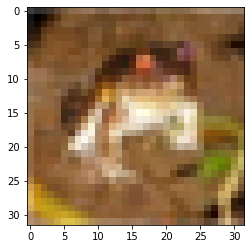

In [8]:
trainiter=iter(trainloader)
img,lab=trainiter.next()
print(lab[0])
plt.imshow(np.transpose(img[0],(1,2,0)))
plt.show()

torch.Size([128])


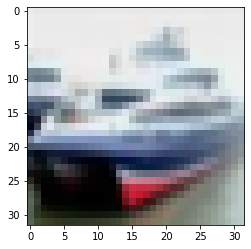

In [9]:
testiter=iter(testloader)
img_t,lab_t=testiter.next()
print(lab_t.shape)
plt.imshow(np.transpose(img_t[1],(1,2,0)))
plt.show()

In [10]:
classes={1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck",0:"airplane"}

#### Define the Model

In [11]:
class MJNet(nn.Module):
    def __init__(self):
        super(MJNet,self).__init__()
        
        self.conv1=nn.Conv2d(3, 32, 3, padding=1)
        self.dropout=nn.Dropout2d(p=0.25)
        self.pool=nn.MaxPool2d(2,2)
#         self.conv2=nn.Conv2d(32,32,3,padding=1)
        self.conv2=nn.Conv2d(32,64,3, padding=1)
        self.conv3=nn.Conv2d(64,64,3, padding=1)
        self.fc1=nn.Linear(64*8*8,512)
        self.fc2=nn.Linear(512,128)
        self.fc3=nn.Linear(128,10)        
        
    def forward(self,x):
        
        x=F.relu(self.conv1(x))
        x=self.dropout(self.pool(F.relu(self.conv2(x))))
        x=self.dropout(self.pool(F.relu(self.conv3(x))))
        x=x.view(-1,64*8*8)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.log_softmax(self.fc3(x), dim=1)
        
        return x
        
net=MJNet().cuda()
print(net)        

MJNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [12]:
criterion=nn.NLLLoss()
optimizer=optim.Adam(net.parameters(), lr=0.0005)
lr_sched=optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

#### Training

In [13]:
for i in range(n_epoch):
    net.train()
    run_loss=0
    count=0
    cnt=0
    run_vloss=0
    for j, (img,labels) in enumerate(trainloader):
        img=img.cuda()
        labels=labels.cuda()
        output=net(img)
        optimizer.zero_grad()
        loss=criterion(output,labels)
        loss.backward()
        optimizer.step()
        count+=1
        run_loss+=loss.item()
    print("train done?")
    net.eval()
    total=0
    correct=0
    for k, (img_t,labels_t) in enumerate(testloader):
        with T.no_grad():
            img_t=img_t.cuda()
            labels_t=labels_t.cuda()
            output_t=net(img_t)
            val_loss=criterion(output_t,labels_t)
            run_vloss+=val_loss.item()
            pred=T.max(output_t.data,1)[1]
            total+=len(labels_t)
            cnt+=1
            correct+=(pred==labels_t).sum()
            accuracy= 100.0 *float(correct)/float(total)
#     lr_sched.step()        
    print('Epoch:{} - Training Loss:{} - Val Loss:{} - Val Accc:{}'.format(i, run_loss/count, run_vloss/cnt, accuracy))               

train done?
Epoch:0 - Training Loss:1.7272362748680212 - Val Loss:1.404647777352152 - Val Accc:49.76
train done?
Epoch:1 - Training Loss:1.3458933595501248 - Val Loss:1.1700779908820043 - Val Accc:58.29
train done?
Epoch:2 - Training Loss:1.1691518328378878 - Val Loss:1.054528408412692 - Val Accc:62.82
train done?
Epoch:3 - Training Loss:1.037516833571217 - Val Loss:0.9430853203882145 - Val Accc:66.65
train done?
Epoch:4 - Training Loss:0.9362166026973968 - Val Loss:0.8788543615160109 - Val Accc:69.18
train done?
Epoch:5 - Training Loss:0.8614769332549151 - Val Loss:0.8395843264422839 - Val Accc:70.51
train done?
Epoch:6 - Training Loss:0.7776104002962332 - Val Loss:0.8151957113531572 - Val Accc:71.75
train done?
Epoch:7 - Training Loss:0.7203468756602548 - Val Loss:0.8043280847464935 - Val Accc:72.73
train done?
Epoch:8 - Training Loss:0.6525085718582964 - Val Loss:0.7953825328923478 - Val Accc:73.03
train done?
Epoch:9 - Training Loss:0.5880507953331598 - Val Loss:0.7778510247604756 

In [14]:
net.eval()
total=0
correct=0
for k, (img_t,labels_t) in enumerate(testloader):
        with T.no_grad():
            img_t=img_t.to('cuda')
            labels_t=labels_t.to('cuda')
            output_t=net(img_t)
            val_loss=criterion(output_t,labels_t)
            pred=T.max(output_t.data,1)[1]
            total+=len(labels_t)
            correct+=(pred==labels_t).sum()
accuracy= 100.0 *float(correct)/float(total)
print('Val accuracy', accuracy)

Val accuracy 74.0


In [15]:
T.save(net.state_dict(),'./cifar-10-cnn-adam.pth')